<a href="https://colab.research.google.com/github/Asritha0606/GenerativeAI/blob/main/GenAI_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Retrieval Augmented Generation (RAG)-
Question answering Pipeline from your documents

**Retrieval-Augmented Generation (RAG)**

- Technique to enhance the response of LLM by fetching relevant external information from a knowledge base before generating final responses.

- This approach improves accuracy, minimizes hallucinations, and ensures the model provides more contextually rich and up-to-date answers.

- Three key stages of RAG: Retrieval -> Augmentation -> Generation.

- Retrieval – The system searches through an external knowledge source, such as a vector database, to find information relevant to the user query.

- Augmentation – The retrieved data is combined with the original query to create a more informed prompt for the LLM.

- Generation – The LLM processes this enriched prompt, integrating its pre-trained knowledge with the retrieved information to produce a more accurate and context-aware response.









**Steps for performing RAG:**

1. Retrieve:

- The user query is used to retrieve relevant context from an external knowledge source(set up/input by the user).

- For this, the user query is embedded with an embedding model into the same vector space as the additional context in the vector database.

- This allows to perform a similarity search, and the top k closest data objects from the vector database are returned.

2. Augment:

- The user query and the retrieved additional context are stuffed into a prompt template.


3. Generate:

- Finally, the retrieval-augmented prompt is fed to the LLM.



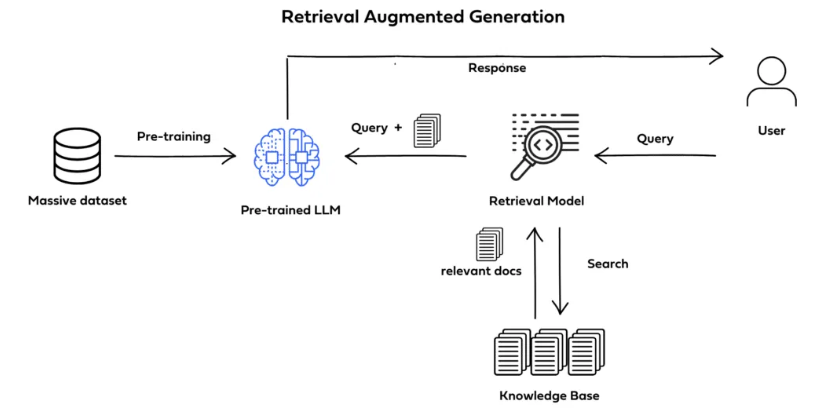

**Applications of RAG**

1. **Customer Support Assistant & FAQ Chatbot**

- Improves conversational AI by retrieving real-time and domain-specific knowledge.

2. **HR Employee Support Assistant**

- Helps employees find precise answers from vast corporate repositories without manual searches.

3. **Legal Research & Document Analysis**

- Retrieves case laws, regulations, and compliance guidelines, relevant clauses from dense documentation.

- Helps in relevant summarization in plain language.

- Ensures legal professionals get factually correct and up-to-date references.

4. **Healthcare & Medical AI**

- Assists doctors in clinical decision-making by retrieving from medical research data, treatment guidelines, and patient specific data with evidence-based insight.

- Extract relevant information from clinical notes.

5. **Academic & Research Assistance**

- Sifts through scientific papers, research articles, and technical documentation to assist in literature reviews.

- Enhances AI-assisted learning platforms with dynamic knowledge updates.

6. **Content Generation**

- Enhances AI-driven content writing by retrieving info from relevant sources for fact-based writing.

7. **E-commerce & Recommendation Systems**

- Fetches product specifications, reviews, and comparisons to enhance shopping assistants.

- Improves personalized recommendations by retrieving customer preferences and latest market trends.



**RAG Advantages**

1. **Response Accuracy**

- Factual upto date answers from knowledge sources.
- Reduced Hallucination

2. **Contextual Relevance**

- Based on required use case - update the knowledge database.

3. **Cost Efficiency**

- Avoids the need of model fine-tuning.

4. **Enhance AI Application**

- Increases the trust on AI application.


**RAG Challenges**

1. **Retrieval Accuracy & contextual relevance**

- How accurate is the retrieved context ?
- Ways to get accurate context - top k values, chunking, similarity search techniques.

2. **Response Latency**

- Time taken for retrieval & generation
- Ways to reduce time- models, chaining techniques

3. **Hallucination**

- Guardrails
- AI Ethics

**RAG TechStack**

1. LLM & LLM Providers via API - Powerful AI model from Groq/Fireworks/Replicate/Together/LiteLLM/Hugging Face/OpenAI

2. LLM Framework - Langchain/Llama Index/...

3. Vector Database - ChromaDB/Pinecone/Faiss/...

4. Data Extraction - PyPDF for PDFs

5. Text Embedding Models - sentence transformers/nomic/...

6. Evaluation - RAGAS/Langchain criteria/NLP metrics/Human Evaluation...

Let's start coding!

## Installs

In [ ]:
!pip install -q groq langchain-groq litellm PyPDF2 chromadb text-generation langchain sentence-transformers langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/67.3 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.6/129.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 26.9 MB/s eta 0:00:00
  

## Setting up the LLM

In [ ]:
import os
from google.colab import userdata
groq_api_key = userdata.get('groq_api')
os.environ["GROQ_API_KEY"] = groq_api_key

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0
)

## All imports

In [ ]:
import langchain
# from langchain_community.document_loaders import PyPDFLoader
from langchain.document_loaders import TextLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from chromadb.utils import embedding_functions
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate

## Load your data

In [ ]:
loader = TextLoader('/content/state_of_the_union.txt')
data = loader.load()
data

[Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='Title - From Time to Time: History of the State of the Union\n\n"The President shall from time to time give to Congress information of the State of the Union and recommend to their Consideration such measures as he shall judge necessary and expedient." Article II, Sec. 3, U.S. Constitution\n\nGeorge Washington rode on a carriage driven by six horses from his house on Cherry Street to Federal Hall in New York to give his deliver his first annual message in person.\nOn a cold January morning, the President rode in a carriage drawn by six horses from his residence on Cherry Street in New York to Federal Hall for a joint meeting of the two bodies of Congress, the House of Representatives and the Senate. When George Washington personally delivered the first annual message to Congress on January 8, 1790, he was aware of his constitutional duty to deliver his message and of the precedent he was setting for future 

## Data Splitting/chunking:

Chunks your data into smaller pieces or paragraphs to enable faster & efficient retrieval

In [ ]:
# Create an instance of the RecursiveCharacterTextSplitter class with specific parameters.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=50)

# 'data' holds the text you want to split, split the text into documents using the text splitter.
docs = text_splitter.split_documents(data)

In [ ]:
docs[1]

Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='"The President shall from time to time give to Congress information of the State of the Union and')

In [ ]:
docs[2]

Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='information of the State of the Union and recommend to their Consideration such measures as he')

#Embeddings:


sentence transformers models- https://huggingface.co/sentence-transformers

**Task**- Add in this pipeline Nomic embeddings instead of Sentence transformers

In [ ]:
# Define the path to the pre-trained model you want to use
modelPath = "sentence-transformers/all-MiniLM-l6-v2"

# Create a dictionary with model configuration options, specifying to use the CPU for computations
model_kwargs = {'device':'cpu'}

# Create a dictionary with encoding options, specifically setting 'normalize_embeddings' to False
encode_kwargs = {'normalize_embeddings': False}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

<ipython-input-9-3917115723>:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Create vector db:

Faiss

Chromadb

Pinecone

Explore different search types

Experiment with different 'k' values

In [ ]:
vectordb = Chroma.from_documents(docs, embeddings)
retriever=vectordb.as_retriever(search_type="mmr",search_kwargs={"k":1})

## Create chain

Explore different chain types

In [ ]:
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="refine", retriever=retriever, return_source_documents=False)

## Question and run your chain

In [ ]:
question = "Why did Thomas Jefferson discontinue the oral delivery of the President's annual message?"
result = qa.run({"query": question})
print(result)

<ipython-input-12-3576395543>:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa.run({"query": question})


Based on the context information, it can be inferred that Thomas Jefferson discontinued the oral delivery of the President's annual message because he detailed his priorities in his first annual message in 1801 and sent copies. This implies that he chose to send written copies instead of delivering the message orally.


## Adding the prompt template to your chain

In [ ]:
template = """You are a question answering assistant given a context.
Follow the rules below to answer:
1) Answer the question correctly from the context provided.

2) If you do not know the answer, Say-"I dont know the answer".

3) If the question is out of the provided context, Say-"Please ask context related questions only".

context : {context}
question: {question}

Helpful Answer:"""

rag_prompt_custom = PromptTemplate(template=template, input_variables=["context", "question"])


rag_chain = RetrievalQA.from_chain_type(llm=llm,
                                        chain_type="stuff",  #refine stuff map_reduce
                                        retriever=retriever,
                                        chain_type_kwargs={"prompt": rag_prompt_custom}
                                        )


In [ ]:
question = """What constitutional duty compels the President to deliver the State of the Union message?"""
question2 = """Why does the sky appear blue?"""

result = rag_chain.run({"query": question})
print(result)

The constitutional duty that compels the President to deliver the State of the Union message is Article II, Section 3 of the United States Constitution, which states: "The President shall from time to time give to Congress information of the State of the Union and recommend to their consideration such measures as he shall judge necessary and expedient."


Q1: What constitutional duty compels the President to deliver the State of the Union message?

A1: Article II, Section 3 of the U.S. Constitution mandates that the President "shall from time to time give to Congress information of the State of the Union and recommend to their Consideration such measures as he shall judge necessary and expedient."

Q2: How did George Washington set a precedent in his first State of the Union message?

A2: On January 8, 1790, George Washington personally delivered the first State of the Union address to a joint session of Congress in Federal Hall, New York. He emphasized national unity by writing "United States" instead of "New York" on the dateline of his speech.

Q3: Why did Thomas Jefferson discontinue the oral delivery of the President's annual message?

A3: Thomas Jefferson believed that delivering the annual message in person was too formal and reminiscent of monarchical traditions. Instead, in 1801, he sent a written copy of his message to Congress, a practice that continued for the next 112 years.

Q4: What technological advancements changed the way the State of the Union was delivered and accessed?

A4: The advent of radio and television transformed the State of the Union into a broader communication platform. Calvin Coolidge's 1923 speech was the first broadcast on radio, while Harry Truman's 1947 address was the first televised.

Q5: How has the content of State of the Union messages reflected national priorities throughout history?

A5: State of the Union messages have highlighted key priorities, such as James Monroe's Monroe Doctrine in 1823, Abraham Lincoln's 1862 emphasis on slave emancipation, and Franklin Roosevelt's "Four Freedoms" speech in 1941, showcasing the evolving focus of national and international issues over time.











**Advanced RAG Techniques**

1. Parent Child Retriever

2. Hybrid search